In [3]:
import numpy as np
import pandas as pd
import scipy.stats as stats
from scipy.stats import zscore, rankdata, kendalltau
from scipy.sparse import csr_matrix
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline
import matplotlib.dates as mdates
import seaborn as sns

import csv 
from collections import Counter
import datetime
import holidays
from sklearn.base import BaseEstimator, TransformerMixin


from sklearn.preprocessing import OneHotEncoder, FunctionTransformer, StandardScaler, RobustScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from scipy.sparse import csr_matrix

import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.outliers_influence import OLSInfluence
from statsmodels.stats.outliers_influence import variance_inflation_factor
from patsy import dmatrices

from lineartree import LinearTreeRegressor

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV, cross_validate
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, explained_variance_score
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor


Methodology changes: (Text from state dashboard at https://mbcolli.shinyapps.io/SARS2EWSP/): 

Note: NYC data and method changes
Quantification methods for SARS-CoV-2 viral RNA changed in March 2023.Real-time reverse transcription
quantitative polymerase chain reaction (RT-qPCR) was used for SARS-CoV-2 N1 gene copy determinations 
for samples collected August 31, 2020-March 7, 2023. Starting with samples collected in March,2023,
digital reverse transcription quantitative polymerase chain reaction (dPCR) has been used. 
Due to differences in methodology, dPCR viral load values are higher than RT-qPCR values. 
Therefore, increases in viral load between March 7th, 2023, and March 12, 2023 are due in 
part to changes in methods. Previously, we displayed the raw data for dPCR starting in May 2023,
however, due to the change , levels in NYC appeared much higher than they actually were. To address this, 
we have temporarily adjusted NYC’s data to make it comparable to older data using a linear adjustment 
that translates the dPCR data to levels comparable to RT-qPCR data.
These new levels are now displayed and present estimates for SARS-CoV-2 levels found in wastewater.

In [4]:
ww_df = pd.read_csv('data/new_SARS-CoV-2_concentrations_measured_in_NYC_Wastewater.csv')

ww_df.head

<bound method NDFrame.head of      Sample Date   Test date       WRRF Name WRRF Abbreviation  \
0     08/31/2020  09/01/2020       26th Ward               26W   
1     08/31/2020  09/01/2020      Bowery Bay                BB   
2     08/31/2020  09/01/2020    Coney Island                CI   
3     08/31/2020  09/01/2020     Hunts Point                HP   
4     08/31/2020  09/01/2020     Jamaica Bay                JA   
...          ...         ...             ...               ...   
3971  08/01/2023  08/02/2023   Port Richmond                PR   
3972  08/01/2023  08/02/2023        Red Hook                RH   
3973  08/01/2023  08/02/2023        Rockaway                RK   
3974  08/01/2023  08/02/2023  Tallman Island                TI   
3975  08/01/2023  08/02/2023    Wards Island                WI   

      Concentration SARS-CoV-2 gene target (N1 Copies/L)   \
0                                                 389.0     
1                                                1204.0

We are just going to look at data using this new testing methodology (dPCR), because we do not know which exact method the city used to adjust between the two. 

In [5]:
# Going to double-check to ensure that all the technology types match the sample date as indicated. That is,
# everything since March 8th should be using the same technology. 

ww_df['Sample Date'] = pd.to_datetime(ww_df['Sample Date'])

# Filter rows from March 2023 onwards
post_march_df = ww_df[ww_df['Sample Date'] >= '2023-03-08']
sorted_test = post_march_df.sort_values(by='Technology')
sorted_date = post_march_df.sort_values(by='Sample Date')



In [6]:
(sorted_test['Sample Date'].reset_index(drop=True) == sorted_date['Sample Date'].reset_index(drop=True)).all()

False

In [7]:
sorted_test.head()
# We can clearly see that that not all testing done after March 7 used the new technology. 

,Sample Date,Test date,WRRF Name,WRRF Abbreviation,Concentration SARS-CoV-2 gene target (N1 Copies/L),Per capita SARS-CoV-2 load (N1 copies per day per population),Annotation,"Population Served, estimated",Technology
3164,2023-03-12,03/13/2023,26th Ward,26W,NaN,NaN,NaN,290608,RT-qPCR
3256,2023-04-04,04/05/2023,Owls Head,OH,5897.0,2120000.0,NaN,906442,RT-qPCR
3255,2023-04-04,04/05/2023,Oakwood Beach,OB,6856.0,NaN,NaN,258731,RT-qPCR
3254,2023-04-04,04/05/2023,North River,NR,4707.0,NaN,NaN,658596,RT-qPCR
3253,2023-04-04,04/05/2023,Newtown Creek,NC,9809.0,5650000.0,NaN,1156473,RT-qPCR


In [8]:
sorted_date.head()

# Again, we can clearly see that that not all testing done after March 7 used the new technogloy. 

,Sample Date,Test date,WRRF Name,WRRF Abbreviation,Concentration SARS-CoV-2 gene target (N1 Copies/L),Per capita SARS-CoV-2 load (N1 copies per day per population),Annotation,"Population Served, estimated",Technology
3164,2023-03-12,03/13/2023,26th Ward,26W,NaN,NaN,NaN,290608,RT-qPCR
3460,2023-03-12,03/13/2023,Coney Island,CI,25680.0,15500000.0,NaN,682342,dPCR
3461,2023-03-12,03/13/2023,Hunts Point,HP,33480.0,20300000.0,NaN,755948,dPCR
3462,2023-03-12,03/13/2023,Jamaica Bay,JA,76632.0,30600000.0,NaN,748737,dPCR
3463,2023-03-12,03/13/2023,Newtown Creek,NC,73584.0,48400000.0,NaN,1156473,dPCR


In [9]:
# Let's look at ratios

tech_counts = post_march_df['Technology'].value_counts()

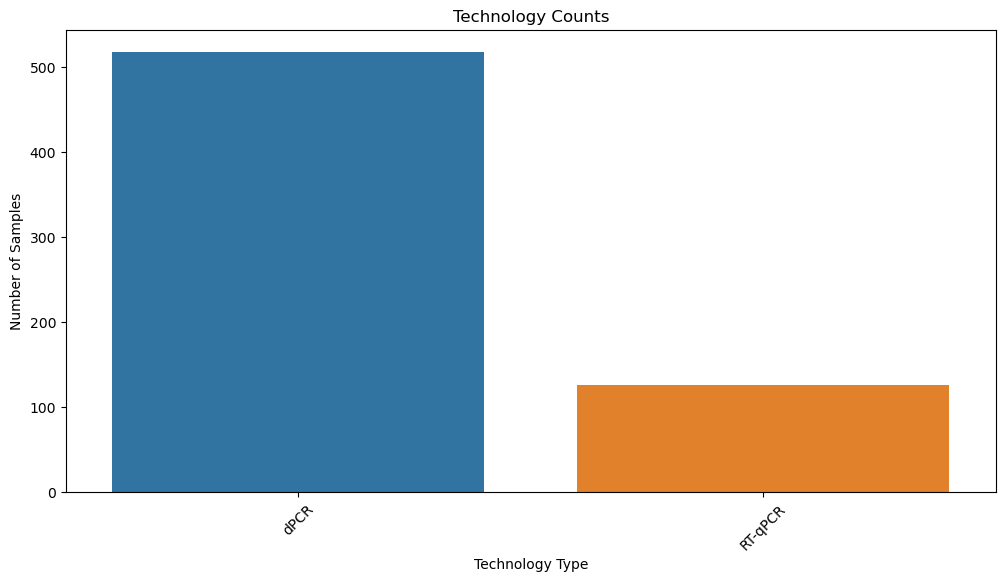

In [10]:
plt.figure(figsize=(12, 6))
sns.barplot(x=tech_counts.index, y=tech_counts.values)
plt.title('Technology Counts')
plt.xlabel('Technology Type')
plt.ylabel('Number of Samples')
plt.xticks(rotation=45)
plt.show()

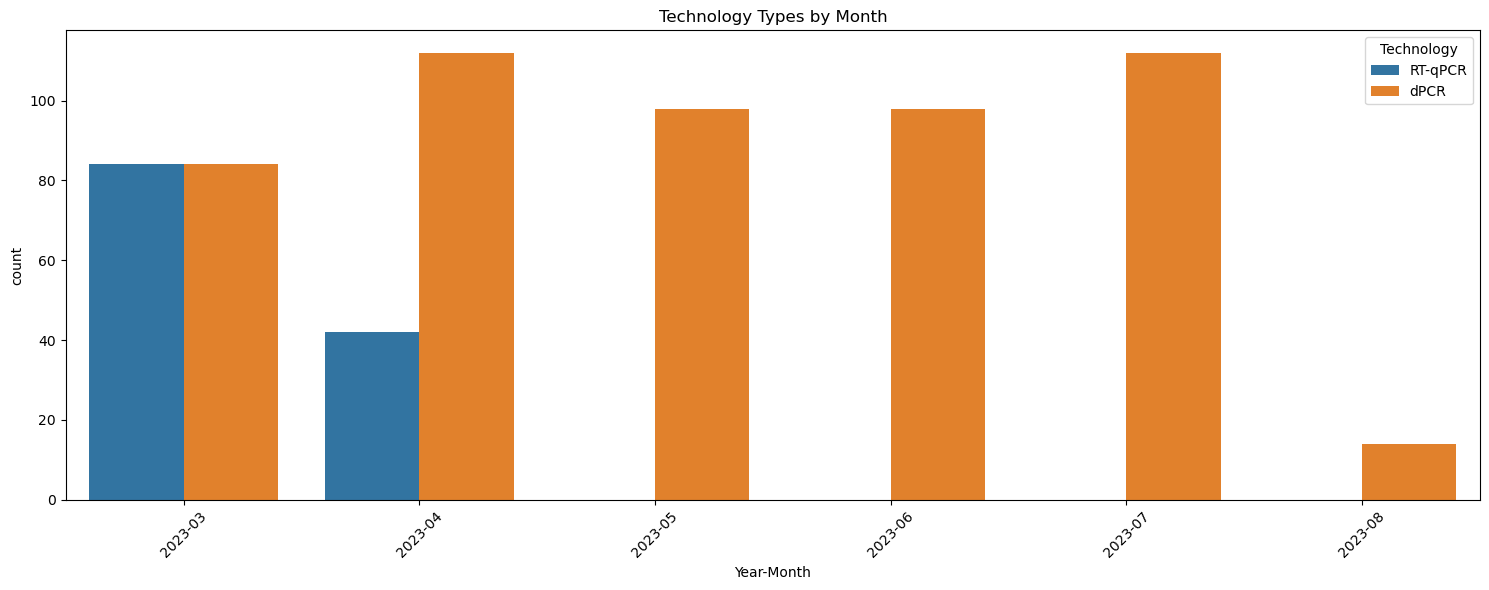

In [11]:
post_march_df_copy = post_march_df.copy()
post_march_df_copy['Year-Month'] = post_march_df['Sample Date'].dt.strftime('%Y-%m')

# Filter unique values and sort, since we have many duplicate dates reflecting testing on the same day at different
# wastewater facilities

unique_dates = sorted(post_march_df_copy['Year-Month'].unique())

plt.figure(figsize=(15, 6))
sns.countplot(data=post_march_df_copy, x='Year-Month', hue='Technology', order=unique_dates)
plt.xticks(rotation=45)
plt.title('Technology Types by Month')
plt.tight_layout()
plt.show()

### Ok, so until May 2023, there was no uniform testing method in place. 

In [12]:
last_date_rt_qpcr = post_march_df[post_march_df['Technology'] == 'RT-qPCR']['Sample Date'].max()

print("The last date when 'RT-qPCR' technology was used:", last_date_rt_qpcr)

The last date when 'RT-qPCR' technology was used: 2023-04-11 00:00:00


In [13]:
# So let's just look at samples after this date. 

dpcr_df = post_march_df[post_march_df['Sample Date'] > '2023-04-11'].copy()
dpcr_df.head()

,Sample Date,Test date,WRRF Name,WRRF Abbreviation,Concentration SARS-CoV-2 gene target (N1 Copies/L),Per capita SARS-CoV-2 load (N1 copies per day per population),Annotation,"Population Served, estimated",Technology
3598,2023-04-16,04/17/2023,26th Ward,26W,30048.0,16800000.0,NaN,290608,dPCR
3599,2023-04-16,04/17/2023,Bowery Bay,BB,59664.0,21200000.0,NaN,924695,dPCR
3600,2023-04-16,04/17/2023,Coney Island,CI,37200.0,15100000.0,NaN,682342,dPCR
3601,2023-04-16,04/17/2023,Hunts Point,HP,33192.0,18100000.0,NaN,755948,dPCR
3602,2023-04-16,04/17/2023,Jamaica Bay,JA,53160.0,19400000.0,NaN,748737,dPCR


In [14]:
# Let's get rid of redudancies, nulls, etc, as with our other datasets. 

dpcr_df.isnull().sum()

Sample Date                                                        0
Test date                                                          0
WRRF Name                                                          0
WRRF Abbreviation                                                  0
Concentration SARS-CoV-2 gene target (N1 Copies/L)                 0
Per capita SARS-CoV-2 load (N1 copies per day per population)     20
Annotation                                                       299
Population Served, estimated                                       0
Technology                                                         0
dtype: int64

In [15]:
# Gotta make sure to drop that Year-Month column we created above for the sake of visualization, as well as nulls.

dpcr_df.dropna(inplace=True)
dpcr_df.drop(labels=['WRRF Abbreviation', 'Test date'], axis=1, inplace=True)


In [16]:
dpcr_df.sample(5)

,Sample Date,WRRF Name,Concentration SARS-CoV-2 gene target (N1 Copies/L),Per capita SARS-CoV-2 load (N1 copies per day per population),Annotation,"Population Served, estimated",Technology
3811,2023-06-20,Hunts Point,65544.0,33100000.0,This sample was analyzed in duplicate.,755948,dPCR
3743,2023-05-30,Newtown Creek,99504.0,59300000.0,This sample was analyzed in duplicate.,1156473,dPCR
3839,2023-06-27,Hunts Point,23064.0,12700000.0,This sample was analyzed in duplicate.,755948,dPCR
3923,2023-07-23,Hunts Point,102840.0,64400000.0,This sample was analyzed in duplicate.,755948,dPCR
3867,2023-07-09,Hunts Point,48984.0,53200000.0,This sample was analyzed in duplicate. *Reran ...,755948,dPCR


In [28]:
dpcr_df.loc[3867]['Annotation']


'This sample was analyzed in duplicate. *Reran on 7/24/23'

In [34]:
duplicated_rows = dpcr_df[dpcr_df.duplicated(subset=['Sample Date', 'Concentration SARS-CoV-2 gene target (N1 Copies/L) '], keep=False)]

# Display the duplicated rows
sorted_dupes = duplicated_rows.sort_values(by=['Sample Date', 'Concentration SARS-CoV-2 gene target (N1 Copies/L) '])

sorted_dupes.head()

,Sample Date,WRRF Name,Concentration SARS-CoV-2 gene target (N1 Copies/L),Per capita SARS-CoV-2 load (N1 copies per day per population),Annotation,"Population Served, estimated",Technology


### Ok, so as assumed, the 'This sample was analyzed in duplicate' annotation value just indicates a quality control measure.